# Using Probabalistic Programming to Simulate Passing Grade Requirements

This short example shows how probabalistic methods can be applied to evaluate beliefs, and simulate results.

This example uses prior distributions to sample random variables to perform Monte Carlo simulations on project grades. Take, for example, a requirement that the collective coursework grade needs to reach a minimum level (B1) to qualify for a distinction when taking into account other results, regardless of current Grade Point Average (GPA).

This final assessment is split into two parts: written and spoken, worth 80% and 20% of the final grade respectively.

Here, we use probabalistic programming to evaluate the possible combination of scores in a grading rubrik required to meet the minimum level, B1 (where GPA=17).

We'll be using the PYMC library to draw samples of random variables, post-processing with Pandas & Numpy then visualizing results in Seaborn.

### Load dependencies

In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import seaborn as sns

### Define probability model

Here marks for each subsection of the written and spoken assessment are generated randomly. Whilst the results are integers (hence should use a discrete distribution like the Poisson distribution) we instead use a Truncated Normal distribution. The reason for this is that there is an upper and lower limit for the achievable grade where the score for each assessed component is $score_{section} = \{0,...,22\}$ 

Note here that we apply different priors based on beliefs. For example, where confident of achieving a good mark the standard deviation is smaller and mean score higher. Likewise, wider priors apply to sections where there is less certainty around the quality of work.

In [2]:
# create probability model for grade marks

''' we could also use a Poisson distribution for this, it would be more intuitive, but truncNormal allows us to compress the range to feasible numbers '''

with pm.Model() as model:
    p_style = pm.TruncatedNormal('style',mu=17,sigma=0.5,lower=0,upper=22)
    p_quality = pm.TruncatedNormal('quality',mu=16,sigma=1,lower=0,upper=22)
    p_approach = pm.TruncatedNormal('approach',mu=15,sigma=2,lower=0,upper=22)
    p_conclusion = pm.TruncatedNormal('conclusion',mu=16,sigma=1,lower=0,upper=22)
    v_content = pm.TruncatedNormal('content',mu=19,sigma=2,lower=0,upper=22)
    v_quality = pm.TruncatedNormal('slide',mu=20,sigma=0.5,lower=0,upper=22)
    v_delivery = pm.TruncatedNormal('delivery',mu=20,sigma=0.5,lower=0,upper=22)
    v_questions = pm.TruncatedNormal('questions',mu=19,sigma=2,lower=0,upper=22)
    trace = pm.sample(10000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [style, quality, approach, conclusion, content, slide, delivery, questions]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 115 seconds.


### Export the samples from the 'posterior' (note we have no data so its not really a posterior) to a Pandas DataFrame

In [3]:
trace = trace['posterior'].to_dataframe()

### Apply post-processing to simulated scores

Here we round our Truncated Normal samples to integers (to represent the score in each assessed component) and we then derive final scores for the written assessment and spoken assessment based on the scoring logic set by the assessors. Note here that the assessors take an average of scores rounded to two decimal places.

Finally, we derive a final score using the 80/20 split mentioned in the introduction.

In [4]:
trace['style'] = np.round(trace['style'])
trace['quality'] = np.round(trace['quality'])
trace['approach'] = np.round(trace['approach'])
trace['conclusion'] = np.round(trace['conclusion'])
trace['content'] = np.round(trace['content'])
trace['slide'] = np.round(trace['slide'])
trace['delivery'] = np.round(trace['delivery'])
trace['questions'] = np.round(trace['questions'])

trace['report_score'] = np.round(trace['style']*0.15 + trace['quality']*0.25 + trace['approach']*0.35 + trace['conclusion']*0.25,2)
trace['viva_score'] = np.round(trace['content']*0.3 + trace['slide']*0.2 + trace['delivery']*0.2 + trace['questions']*0.3,2)

trace['final_score'] = np.round(trace['report_score'] * 0.8 + trace['viva_score']*0.2,2)

Our samples look something like this...

In [5]:
trace.head()

style  quality  approach  conclusion  content  slide  delivery  \
chain draw                                                                   
0     0      17.0     16.0      15.0        17.0     19.0   20.0      20.0   
      1      17.0     15.0      15.0        16.0     19.0   20.0      20.0   
      2      17.0     16.0      16.0        16.0     17.0   20.0      20.0   
      3      17.0     17.0      16.0        16.0     16.0   20.0      20.0   
      4      17.0     15.0      13.0        17.0     21.0   20.0      20.0   

            questions  report_score  viva_score  final_score  
chain draw                                                    
0     0          17.0         16.05        18.8        16.60  
      1          19.0         15.55        19.4        16.32  
      2          15.0         16.15        17.6        16.44  
      3          18.0         16.40        18.2        16.76  
      4          16.0         15.10        19.1        15.90

Now we can use this information to derive insight on our beliefs!

Here we use the Numpy <i>where</i> function to create a binary indicator on whether we met the passing grade for distinction overall

In [6]:
trace['grade_achieved'] = np.where(trace['final_score']>=16.5,1,0)

Our final results now have a column which we can use to understand the possible score combinations needed to get a good mark.

In [7]:
trace.head()

style  quality  approach  conclusion  content  slide  delivery  \
chain draw                                                                   
0     0      17.0     16.0      15.0        17.0     19.0   20.0      20.0   
      1      17.0     15.0      15.0        16.0     19.0   20.0      20.0   
      2      17.0     16.0      16.0        16.0     17.0   20.0      20.0   
      3      17.0     17.0      16.0        16.0     16.0   20.0      20.0   
      4      17.0     15.0      13.0        17.0     21.0   20.0      20.0   

            questions  report_score  viva_score  final_score  grade_achieved  
chain draw                                                                    
0     0          17.0         16.05        18.8        16.60               1  
      1          19.0         15.55        19.4        16.32               0  
      2          15.0         16.15        17.6        16.44               0  
      3          18.0         16.40        18.2        16.76               1  
      4          16.0         15.10        19.1        15.90               0

### Visualizing the Monte Carlo simulations with Seaborn

Firstly, we can see that whilst we've derived two separate measures for performance as deterministic variables (i.e. written and spoken assessmnet), the assessed components all came from the Truncated Normal distribution. Plotting the bivariate density of these outputs we can see that both are normally distributed and density is highest around our beliefs (where our prior belief in this case is that we're likely to do better in the spoken assessment than the written assessment)

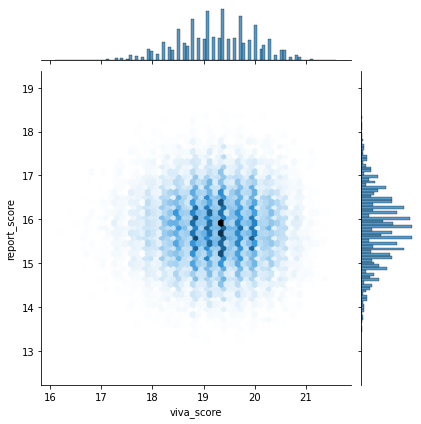

In [8]:
sns.jointplot(x=trace['viva_score'],y=trace['report_score'],kind='hex')

Finally, we can visualize our binary indicator on a scatterplot showing the linear combinations for final score which could result in us achieving the minimum grade for attaining a distinction overall.

<AxesSubplot: xlabel='viva_score', ylabel='report_score'>

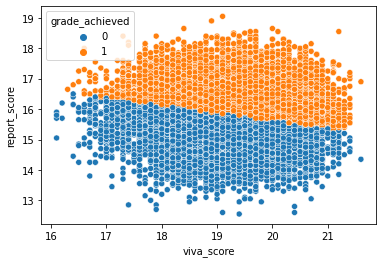

In [9]:
sns.scatterplot(x=trace['viva_score'],y=trace['report_score'],hue=trace['grade_achieved'])

Why use these prior beliefs? They're a convenient middle ground where the lazy student balances on the knife-edge of reaching the passing grade. We can get a point estimate from our simulations for the probability of hitting the pass mark. If we assumed that we were destined to fail or pass with flying colours, we might not gain much insight on the possible combinations

In [11]:
# probability of getting a B1 based on current beliefs

num_b1 = trace['grade_achieved'].sum()
num_sim = trace.shape[0]

print(num_b1 / num_sim)

0.499375


### In Summary...

This short and simple example shows how probabalistic programming frameworks can be a useful tool for scenario analysis and planning. From the results above we can see that provided we get a strong grade of around 20 in the spoken assessment, its possible to still hit the mark with a written grade as low as around 15.5, around 1.5 GPA lower than the mark of B1.